#  Audio Emotion Recognition

> Audio emotion recognition is a field of artificial intelligence and signal processing that focuses on the automatic detection and analysis of human emotions from audio data, such as speech or music

### This Project Has Been Divided Into 9 Parts
- Understanding "Audio" Data
- Creating Metadata
- Extracting Data
- Exploring Data
- Mel-frequency cepstral coefficients (MFCCs)
- Processing Data for Deep Learning
- Setting up Deep Learning Model
- Training and Testing The Model
- Results

## 1. Understanding "Audio" Data

> "Audio" refers to sound, particularly in the form of vibrations or waves that travel through a medium, such as air, water, or solid objects
#### How Sound is Represented?
There are severel ways in which we can represent a sound wave. But the important ones are: 
- Time Domain
>We usually represent the sound in the form of the waveform. The plot is made w.r.t "Time" & "Amplitude"
<img src = "waveform_img.png" style = "width:400px;height:200px"/>
- Frequency Domain
> Here we represent the sound in the form of Spectogram. The plot is made w.r.t "Frequency" & "Amplitude" & "Phase"
<img src = "spectogram_img.png" style = "width:400px;height:200px"/>

## Importing Libraries

In [183]:
import os
import librosa
from librosa.display import waveshow
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile
import warnings
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from librosa.feature import melspectrogram
import visualkeras
import pydot_ng
import pydotplus
import graphviz
warnings.filterwarnings('ignore')

## 2. Creating Metadata

#### Creating Metadata

The following recursive function traverses through each folder and file, and returns audio files in a list.

In [2]:
def get_metadata(path, list_of_files, class_) :
    
    ## list of all content in the folder
    file_folder = os.listdir(path)
    temp_class = class_
    
    ## travering each content
    for content in file_folder :
        ## if file then append
        if '.wav' in content :
            list_of_files.append((path + '/' + content, class_))
        ## if folder, then make a recursive call
        else :
            temp_class += 1
            get_metadata(path + '/' + content, list_of_files, temp_class)

#### Initializing Variables

In [3]:
path = r'TESS Toronto emotional speech set data'
metadata = []
class_initial = -1

#### Function Call

In [4]:
get_metadata(path, metadata, class_initial)

#### Metadata

In [5]:
metadata = pd.DataFrame(metadata, columns = ['File_name', 'class'])
metadata

,File_name,class
0,TESS Toronto emotional speech set data/OAF_ang...,0
1,TESS Toronto emotional speech set data/OAF_ang...,0
2,TESS Toronto emotional speech set data/OAF_ang...,0
3,TESS Toronto emotional speech set data/OAF_ang...,0
4,TESS Toronto emotional speech set data/OAF_ang...,0
...,...,...
2795,TESS Toronto emotional speech set data/YAF_sad...,13
2796,TESS Toronto emotional speech set data/YAF_sad...,13
2797,TESS Toronto emotional speech set data/YAF_sad...,13
2798,TESS Toronto emotional speech set data/YAF_sad...,13


In [6]:
## adding age factor
age_factor = list()
for class_ in metadata['class'] :
    if class_ < 7 :
        age_factor.append('young')
    else :
        age_factor.append('old')
metadata['Age_Factor'] = age_factor

df = metadata.copy()

def change_class(num_class) :
    if (num_class >= 7) :
        num_class -= 7
    return num_class

new_class = df['class'].apply(change_class)

df['class'] = new_class

df

,File_name,class,Age_Factor
0,TESS Toronto emotional speech set data/OAF_ang...,0,young
1,TESS Toronto emotional speech set data/OAF_ang...,0,young
2,TESS Toronto emotional speech set data/OAF_ang...,0,young
3,TESS Toronto emotional speech set data/OAF_ang...,0,young
4,TESS Toronto emotional speech set data/OAF_ang...,0,young
...,...,...,...
2795,TESS Toronto emotional speech set data/YAF_sad...,6,old
2796,TESS Toronto emotional speech set data/YAF_sad...,6,old
2797,TESS Toronto emotional speech set data/YAF_sad...,6,old
2798,TESS Toronto emotional speech set data/YAF_sad...,6,old


## 3. Extracting Data

The Following Function loads the audio files and return the Audio Signals

In [7]:
def return_audio(files) :
    
    ## audio signals is the array of all the loaded audio files.
    audio_signals = []
    
    for file_path in files :
        ## the load() returns the array of signal and sample rate w.r.t time, for any audio file.
        audio, sample_rate = librosa.load(file_path)
        audio_signals.append(audio)
    
    return audio_signals

In [8]:
audio_signals = return_audio(np.array(df['File_name']))

In [9]:
## defining constant sample rate
sample_rate = 22050

## 4. Exploring Data

In [10]:
sample_audio = audio_signals[43]
list(sample_audio[:10])

[7.744362e-06,
 6.4317275e-05,
 0.00030629704,
 0.00042276765,
 0.00038549458,
 0.0002547398,
 0.0002435121,
 0.0003011384,
 0.00033421145,
 0.0003824557]

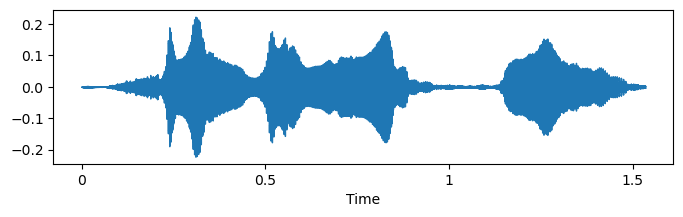

In [11]:
plt.figure(figsize=(8,2))
waveshow(sample_audio, sr = sample_rate)
Audio(data = sample_audio, rate = sample_rate)

- The above signal is of TIME DOMAIN
> The follwing audio file is converted into an array of signals.
- Note: The Audio Signals are represented in the form of array of amplitude in each time instance
<img src = "waveform load.png" style = "width:400px;height:200px"/>

In [12]:
df.to_csv('Class_ditribution.csv')

In [13]:
class_distribution = df['class'].value_counts().to_dict()
class_distribution

{0: 400, 1: 400, 2: 400, 3: 400, 4: 400, 5: 400, 6: 400}

<BarContainer object of 7 artists>

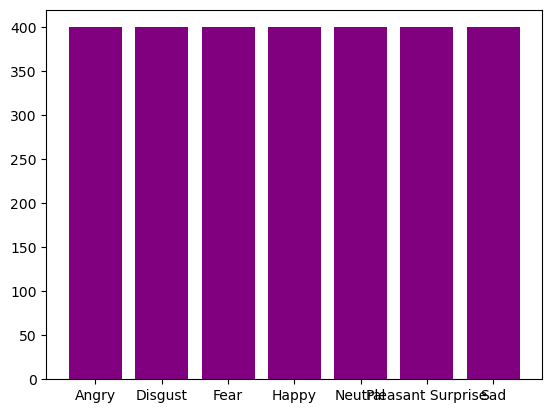

In [14]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Pleasant Surprise', 'Sad']
count = list(class_distribution.values())

plt.bar(emotions, count, color = 'purple')

## 5. Mel-frequency cepstral coefficients (MFCCs) 


Mel-Frequency Cepstral Coefficients (MFCCs) are a crucial feature extraction technique widely used in the field of audio signal processing and speech recognition. They are particularly important due to their effectiveness in capturing essential patterns and characteristics in audio signals, especially for speech and audio analysis tasks. Here's an explanation of their importance and how they capture patterns in audio

MFCCs are needed to Capture Patterns in Audio:

- MFCCs capture patterns in audio by breaking down the audio signal into frames (typically around 20-30 milliseconds each).

- For each frame, a Fourier Transform is applied to compute the power spectrum of the signal.

- The power spectrum is then filtered through a bank of Mel filters, which approximate human auditory perception.

- After filtering, the logarithm of the filter bank outputs is taken, followed by a Discrete Cosine Transform (DCT) to obtain the MFCC coefficients.

- These coefficients represent the audio signal's spectral content for each frame.

<img src = "mfccs_img.png" style = "width:600;height:400px"/>

#### Extracting MFCCs from Audio Files

In [15]:
def extract_MFCCs(audio_signal, sample_rate) :
    mfccs = (librosa.feature.mfcc(y = audio_signal, sr = sample_rate, n_mfcc = 20)).T
    mfccs = np.mean(mfccs, axis = 0)
    return mfccs

In [16]:
sample_rate = 22050
mfccs = list()
for audio in audio_signals :
    mfccs.append(extract_MFCCs(audio , sample_rate))

In [17]:
mfccs = pd.DataFrame(mfccs)
mfccs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-383.432617,52.460812,-17.608944,-11.810311,-4.707630,7.513891,-25.082636,-6.948460,-10.093306,-3.254937,0.281038,0.656696,2.047499,2.982287,4.187005,1.354461,-3.593895,-2.941231,-3.203928,-8.714863
1,-444.550110,65.292038,-2.571654,-20.355953,-10.516433,10.241208,-9.607938,-1.355310,-12.456924,2.827871,-9.535598,9.995904,-0.791078,4.928980,1.611719,0.394611,-5.794950,-4.143381,-3.314804,-8.888523
2,-402.192657,26.256584,-5.023631,-0.407520,-0.952224,0.913046,-19.256067,-2.460230,-13.165890,-1.056540,-12.630615,7.668492,-0.763719,6.849833,-1.808660,-0.068707,-2.023834,-1.856652,-6.333825,-9.804387
3,-383.497040,52.386791,-11.534899,-13.975940,-3.906754,6.814112,-21.693228,-7.680974,-13.304781,-3.169330,-1.643530,1.388642,0.603746,0.421453,6.513353,-1.337453,-5.334017,0.009898,-4.866846,-8.642750
4,-398.562683,51.876442,3.370301,8.665921,3.880992,0.732045,-24.158323,7.486300,-19.511465,-12.444627,-11.401490,-1.805533,-4.849055,3.649373,-6.593769,-0.749293,-3.080799,-0.836121,-5.029727,-11.009469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,-391.547699,61.473328,34.779984,42.554768,-2.182075,8.699821,-1.409615,-11.303340,0.550166,-4.555710,-5.787300,5.773145,-6.542877,9.318780,-6.681866,0.084128,3.296575,-3.551843,-4.491244,-0.790411
2796,-404.340485,76.251541,25.959827,39.575932,0.379420,-0.940992,-6.228340,-14.371888,1.734153,-11.790402,-8.991035,2.880116,-9.387178,6.195618,-8.639506,-2.452828,-1.732491,-3.917350,-7.079430,-3.179536
2797,-370.484589,65.668495,38.364941,41.208473,-4.550176,4.382659,-0.712864,-9.426854,2.177757,-7.615240,-7.580241,1.071735,-10.043199,6.073882,-6.675931,-3.318172,1.640053,-2.373909,-11.508492,-2.538772
2798,-423.077972,69.036842,29.720037,37.226368,-3.204174,13.681798,-3.380288,-12.161002,-0.653988,-4.454651,-6.846123,-2.102363,-7.402556,6.668041,-6.072210,0.149884,-1.666963,-4.153022,-4.962617,-3.688081


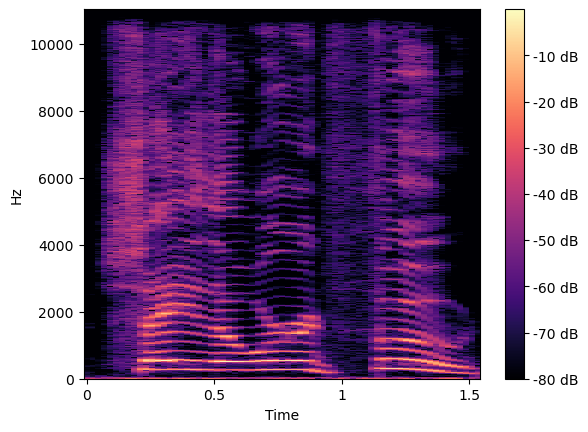

In [18]:
D = librosa.stft(sample_audio)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

## 6. Processing Data for Deep Learning

#### Train Test Split

In [65]:
feature_data = mfccs.values
target = df['class']

In [66]:
x_train, x_test, y_train, y_test = train_test_split(feature_data, target, random_state = 42)

#### Checking Shapes

In [67]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2100, 20), (700, 20), (2100,), (700,))

In [68]:
coeff = 20

#### Converting Data w.r.t Neural Network

In [69]:
x_train_reshaped = x_train.reshape(x_train.shape[0], coeff, 1)
y_train_reshaped = to_categorical(y_train, num_classes=len(set(target)), dtype='int')
x_test_reshaped = x_test.reshape(x_test.shape[0], coeff, 1)
y_test_reshaped = to_categorical(y_test, num_classes=len(set(target)), dtype='int')

## 7. Setting up Model for Deep Learning

#### The Model that will be used will be a Sequentioal Convolutional Neural Networks
<img src = "CNN_img.jpg"/>

#### Why CNN?
Convolutional Neural Networks (CNNs) are primarily associated with image processing, but they can also be adapted for audio classification tasks, such as speech recognition, music genre classification, or environmental sound classification. To apply CNNs to audio data, we can use a spectrogram representation and follow a similar architecture as in image-based CNNs

#### Model Creation

In [200]:
class Audio_Classification :
    
    def __init__(self, coeff) :
        self.model = Sequential()
        input_shape = (coeff, 1)
        self.model.add(Conv1D(32, kernel_size=3, activation='selu', input_shape=input_shape))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Conv1D(64, kernel_size=3, activation='selu'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='selu'))
        self.model.add(Dense(7, activation='softmax'))
        self.model.compile(loss = 'CategoricalCrossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    def fit(self, x, y, epochs, validation) :
        self.model.fit(x, y, epochs = epochs, validation_data = validation)

    def predict(self, x) :
        y_pred = self.model.predict(x)
        for i in range(len(y_pred)) :
            y_pred[i] = np.argmax(y_pred[i])
        y_pred = np.array(y_pred[:, 0], dtype = int)
        return y_pred
    
    def plot(self) :
        return keras.utils.plot_model(
            self.model,
            to_file="Clf.png",
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            rankdir="TB",
            expand_nested=True,
            dpi=96,
            layer_range=None,
            show_layer_activations=True,
            show_trainable=False,
        )

## 8. Training and Testing

#### Creating Classifier

In [134]:
clf = Audio_Classification(coeff = coeff)

#### Training

In [135]:
clf.fit(x_train_reshaped, y_train_reshaped, epochs = 300, validation = (x_test_reshaped, y_test_reshaped))

Epoch 1/300
66/66 [==============================] - 1s 5ms/step - loss: 2.3985 - accuracy: 0.5395 - val_loss: 0.5572 - val_accuracy: 0.7943
Epoch 2/300
66/66 [==============================] - 0s 3ms/step - loss: 0.3838 - accuracy: 0.8738 - val_loss: 0.3372 - val_accuracy: 0.8757
Epoch 3/300
66/66 [==============================] - 0s 3ms/step - loss: 0.2523 - accuracy: 0.9171 - val_loss: 0.2002 - val_accuracy: 0.9371
Epoch 4/300
66/66 [==============================] - 0s 2ms/step - loss: 0.1617 - accuracy: 0.9490 - val_loss: 0.1689 - val_accuracy: 0.9486
Epoch 5/300
66/66 [==============================] - 0s 2ms/step - loss: 0.1320 - accuracy: 0.9586 - val_loss: 0.1686 - val_accuracy: 0.9471
Epoch 6/300
66/66 [==============================] - 0s 3ms/step - loss: 0.1156 - accuracy: 0.9600 - val_loss: 0.1496 - val_accuracy: 0.9471
Epoch 7/300
66/66 [==============================] - 0s 2ms/step - loss: 0.1095 - accuracy: 0.9605 - val_loss: 0.1165 - val_accuracy: 0.9657
Epoch 8/300
6

66/66 [==============================] - 0s 3ms/step - loss: 7.0884e-05 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.9786
Epoch 115/300
66/66 [==============================] - 0s 3ms/step - loss: 6.7543e-05 - accuracy: 1.0000 - val_loss: 0.0760 - val_accuracy: 0.9786
Epoch 116/300
66/66 [==============================] - 0s 2ms/step - loss: 6.9877e-05 - accuracy: 1.0000 - val_loss: 0.0772 - val_accuracy: 0.9786
Epoch 117/300
66/66 [==============================] - 0s 2ms/step - loss: 6.2560e-05 - accuracy: 1.0000 - val_loss: 0.0762 - val_accuracy: 0.9786
Epoch 118/300
66/66 [==============================] - 0s 2ms/step - loss: 6.5596e-05 - accuracy: 1.0000 - val_loss: 0.0761 - val_accuracy: 0.9786
Epoch 119/300
66/66 [==============================] - 0s 2ms/step - loss: 6.0868e-05 - accuracy: 1.0000 - val_loss: 0.0757 - val_accuracy: 0.9786
Epoch 120/300
66/66 [==============================] - 0s 2ms/step - loss: 5.4704e-05 - accuracy: 1.0000 - val_loss: 0.0766 - val_ac

Epoch 170/300
66/66 [==============================] - 0s 2ms/step - loss: 9.7503e-06 - accuracy: 1.0000 - val_loss: 0.0849 - val_accuracy: 0.9786
Epoch 171/300
66/66 [==============================] - 0s 2ms/step - loss: 9.4028e-06 - accuracy: 1.0000 - val_loss: 0.0859 - val_accuracy: 0.9786
Epoch 172/300
66/66 [==============================] - 0s 2ms/step - loss: 8.9687e-06 - accuracy: 1.0000 - val_loss: 0.0856 - val_accuracy: 0.9786
Epoch 173/300
66/66 [==============================] - 0s 2ms/step - loss: 8.9639e-06 - accuracy: 1.0000 - val_loss: 0.0862 - val_accuracy: 0.9800
Epoch 174/300
66/66 [==============================] - 0s 2ms/step - loss: 8.4974e-06 - accuracy: 1.0000 - val_loss: 0.0853 - val_accuracy: 0.9786
Epoch 175/300
66/66 [==============================] - 0s 2ms/step - loss: 8.1533e-06 - accuracy: 1.0000 - val_loss: 0.0862 - val_accuracy: 0.9800
Epoch 176/300
66/66 [==============================] - 0s 2ms/step - loss: 7.7030e-06 - accuracy: 1.0000 - val_loss: 0

Epoch 226/300
66/66 [==============================] - 0s 2ms/step - loss: 1.3972e-06 - accuracy: 1.0000 - val_loss: 0.1020 - val_accuracy: 0.9800
Epoch 227/300
66/66 [==============================] - 0s 2ms/step - loss: 1.3753e-06 - accuracy: 1.0000 - val_loss: 0.1011 - val_accuracy: 0.9800
Epoch 228/300
66/66 [==============================] - 0s 2ms/step - loss: 1.3210e-06 - accuracy: 1.0000 - val_loss: 0.1003 - val_accuracy: 0.9814
Epoch 229/300
66/66 [==============================] - 0s 2ms/step - loss: 1.2416e-06 - accuracy: 1.0000 - val_loss: 0.0997 - val_accuracy: 0.9814
Epoch 230/300
66/66 [==============================] - 0s 2ms/step - loss: 1.1873e-06 - accuracy: 1.0000 - val_loss: 0.1024 - val_accuracy: 0.9800
Epoch 231/300
66/66 [==============================] - 0s 2ms/step - loss: 1.1730e-06 - accuracy: 1.0000 - val_loss: 0.1030 - val_accuracy: 0.9800
Epoch 232/300
66/66 [==============================] - 0s 2ms/step - loss: 1.1413e-06 - accuracy: 1.0000 - val_loss: 0

Epoch 282/300
66/66 [==============================] - 0s 2ms/step - loss: 1.8341e-07 - accuracy: 1.0000 - val_loss: 0.1202 - val_accuracy: 0.9800
Epoch 283/300
66/66 [==============================] - 0s 2ms/step - loss: 1.7467e-07 - accuracy: 1.0000 - val_loss: 0.1203 - val_accuracy: 0.9800
Epoch 284/300
66/66 [==============================] - 0s 2ms/step - loss: 1.6865e-07 - accuracy: 1.0000 - val_loss: 0.1200 - val_accuracy: 0.9800
Epoch 285/300
66/66 [==============================] - 0s 2ms/step - loss: 1.6468e-07 - accuracy: 1.0000 - val_loss: 0.1208 - val_accuracy: 0.9800
Epoch 286/300
66/66 [==============================] - 0s 2ms/step - loss: 1.5560e-07 - accuracy: 1.0000 - val_loss: 0.1201 - val_accuracy: 0.9800
Epoch 287/300
66/66 [==============================] - 0s 2ms/step - loss: 1.5134e-07 - accuracy: 1.0000 - val_loss: 0.1207 - val_accuracy: 0.9800
Epoch 288/300
66/66 [==============================] - 0s 2ms/step - loss: 1.4498e-07 - accuracy: 1.0000 - val_loss: 0

#### Testing

In [136]:
y_pred = clf.predict(x_test_reshaped)
y_pred

22/22 [==============================] - 0s 1ms/step


array([5, 3, 3, 5, 2, 1, 6, 0, 4, 5, 5, 5, 3, 5, 3, 2, 3, 6, 1, 5, 6, 0,
       2, 6, 5, 2, 5, 4, 0, 6, 4, 2, 0, 3, 3, 2, 1, 4, 0, 6, 2, 0, 3, 1,
       6, 2, 0, 4, 6, 3, 1, 4, 4, 2, 5, 5, 2, 4, 2, 1, 2, 6, 6, 4, 5, 4,
       0, 1, 6, 3, 5, 2, 1, 5, 0, 6, 4, 6, 3, 0, 5, 0, 0, 6, 6, 4, 1, 1,
       6, 2, 1, 3, 5, 4, 0, 6, 4, 5, 5, 3, 3, 6, 5, 5, 6, 3, 6, 2, 3, 6,
       4, 4, 4, 0, 3, 2, 0, 0, 5, 2, 3, 6, 4, 0, 3, 6, 0, 6, 3, 5, 5, 2,
       1, 5, 5, 0, 3, 0, 5, 4, 0, 5, 4, 4, 0, 6, 4, 0, 4, 3, 6, 5, 4, 6,
       5, 5, 0, 3, 3, 1, 4, 2, 4, 1, 1, 1, 4, 0, 0, 5, 0, 1, 1, 2, 1, 3,
       4, 0, 5, 0, 4, 5, 0, 3, 6, 6, 6, 1, 4, 1, 2, 0, 1, 4, 2, 5, 6, 0,
       2, 5, 5, 5, 2, 6, 3, 6, 2, 2, 3, 4, 0, 0, 3, 6, 2, 0, 5, 0, 6, 6,
       6, 1, 2, 4, 3, 6, 0, 3, 5, 2, 6, 6, 0, 5, 2, 1, 2, 2, 3, 5, 6, 4,
       0, 2, 1, 0, 1, 4, 6, 4, 3, 5, 2, 2, 5, 1, 5, 3, 2, 4, 5, 6, 1, 0,
       3, 2, 1, 6, 5, 0, 3, 1, 4, 2, 3, 6, 0, 6, 4, 6, 4, 3, 6, 0, 0, 1,
       0, 0, 2, 4, 1, 5, 5, 4, 6, 1, 4, 4, 0, 1, 4,

#### Plot Model

In [201]:
viz_clf = Audio_Classification(coeff = coeff)

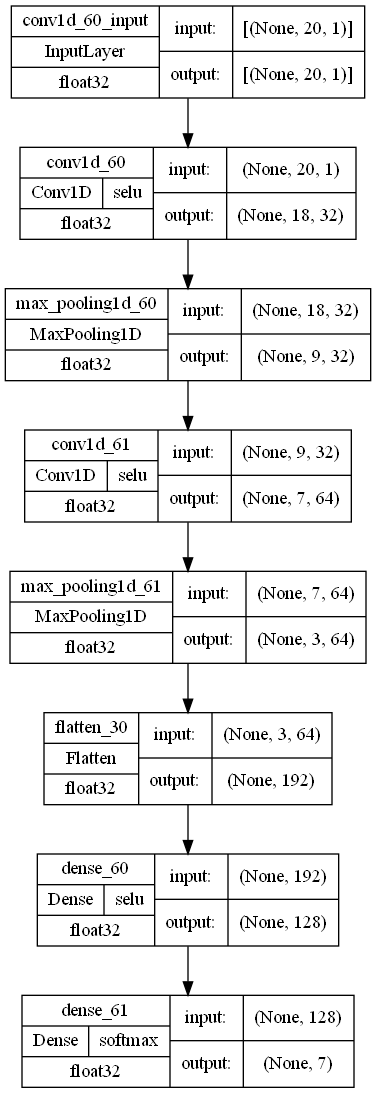

In [202]:
viz_clf.plot()

## 9. Results

In [141]:
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Accuracy : ",accuracy_score(y_test, y_pred) * 100, '%')

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        97
           1       0.99      0.98      0.99       101
           2       0.97      0.97      0.97       111
           3       0.99      0.96      0.97        98
           4       0.99      0.98      0.98        91
           5       0.96      0.97      0.97       104
           6       0.99      1.00      0.99        98

    accuracy                           0.98       700
   macro avg       0.98      0.98      0.98       700
weighted avg       0.98      0.98      0.98       700

Accuracy :  98.0 %


Text(0.5, 1.0, 'Confusion Matrix')

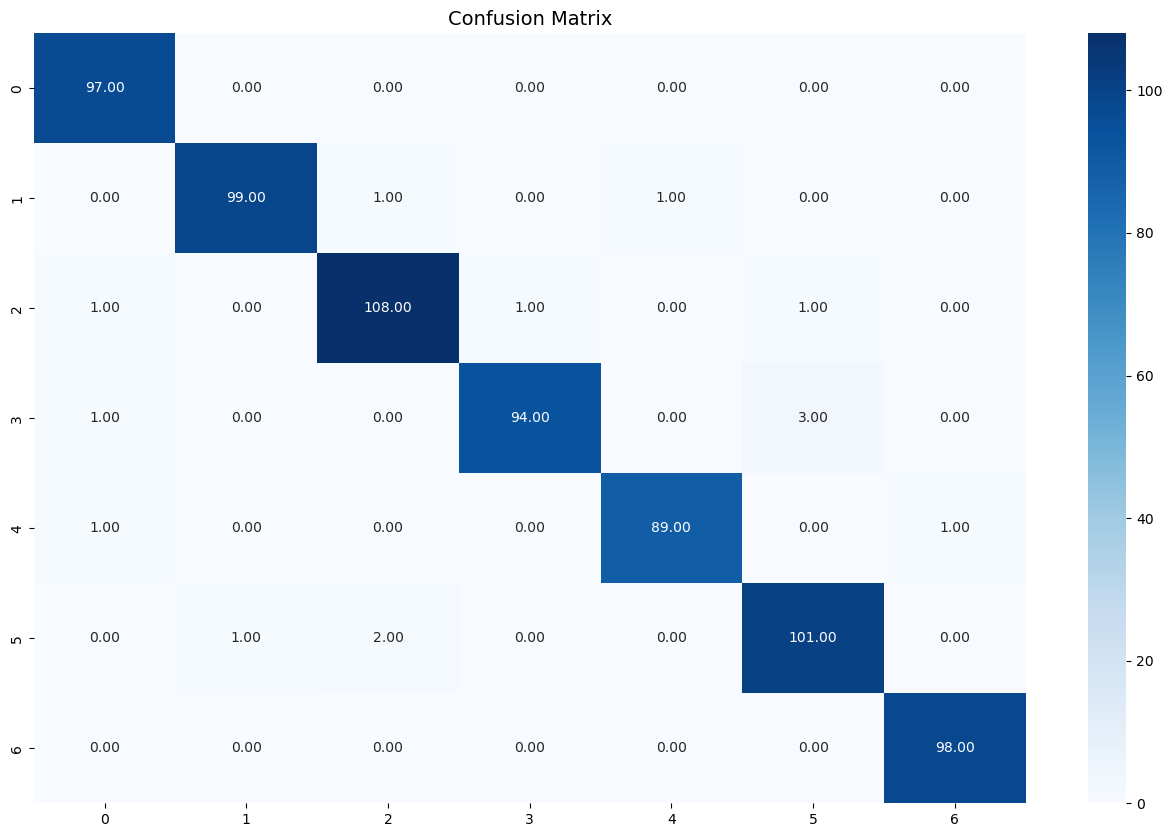

In [139]:
cm= confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm,annot=True, fmt='.2f', cmap = 'Blues')
plt.title('Confusion Matrix', fontsize=14)